In [1]:
import math
import collections
import pickle
import random
import scipy
import json

from matplotlib import pyplot as plt

import GPy
import numpy as np
import pandas as pd
from tqdm import tqdm
# from DataPrep_V2 import data_prep, exp_data_collection, get_test_data

# from Kernel import MixtureViaSumAndProduct, CategoryOverlapKernel
from methods.InitialData_Gen import initialize
# from methods.AcquisitionFunctions import EI, PI, UCB, AcquisitionOnSubspace
# from SamplingCategorical import compute_prob_dist_and_draw_hts
from methods.UpdateCategoricalWeight import compute_reward_for_all_cat_variable, update_weights_for_all_cat_var
# from methods.optimization import sample_then_minimize

from methods.AskTell import ask_tell
from scipy import linalg
# from numpy.linalg import LinAlgError

from scipy.optimize import minimize

from typing import Union, Tuple
from paramz.transformations import Logexp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

1. C - List of number of categroies corresponding to each categorical variable
2. Nc - Number of categorical variables
3. Nx - Continuous variables
4. h - categorical
5. x - continuous
6. z - [h, x]

7. nDim - Nc + Nx
8. bounds - Lower and Upper bounds of both Catergorical variables and continuous variables

9. n_iter - Number of iterations to run the algorithm
10. initN - Number of intial data points
11. batch_size (b) - Number of experiments to be generated in each iteration

12. acq_type - Acquisition Type
13. Meas_Noise - Measurement Noise in the target 
14. Trade-off : Explorarion exploitation balance

In [2]:
from methods.AskTell import Scaling_data
import GPy
from methods.Kernel import MixtureViaSumAndProduct, CategoryOverlapKernel

In [3]:
def get_kernel(data_param, cont_kernel_name, length_scale = None, mix = None):
    
    default_cont_lengthscale = length_scale #[0.1] * data_param['Nx']  # cont lengthscale
    default_variance = 1  # Variance is the multiplication factor that appears in the kernel
    if data_param['approach_type'] == 'CoCa':
        continuous_dims = list(range(data_param['Nc'], data_param['nDim']))
        categorical_dims = list(range(data_param['Nc']))
    else:
        continuous_dims = list(range(0, data_param['Nx']))
    
    fix_mix_in_this_iter = False
    if mix is None:
        mix_value = 0.5
    else:
        mix_value = mix
    
    if length_scale is None:
        if cont_kernel_name == 'Matern52':
            k_cont = GPy.kern.Matern52(data_param['Nx'], variance=default_variance, #lengthscale = default_cont_lengthscale,
                                       active_dims=continuous_dims, ARD=True)  # continuous kernel
        elif cont_kernel_name == 'Matern32':
            k_cont = GPy.kern.Matern32(data_param['Nx'],variance=default_variance,
                                       active_dims=continuous_dims, ARD=True)  # continuous kernel
        else:
            k_cont = GPy.kern.RBF(data_param['Nx'], variance=default_variance,
                                  active_dims=continuous_dims, ARD=True)  # continuous kernel
    else:
        assert len(length_scale) == data_param['Nx'] 
        if cont_kernel_name == 'Matern52':
            k_cont = GPy.kern.Matern52(data_param['Nx'], variance=default_variance, lengthscale = default_cont_lengthscale,
                                       active_dims=continuous_dims, ARD=True)  # continuous kernel
        elif cont_kernel_name == 'Matern32':
            k_cont = GPy.kern.Matern32(data_param['Nx'],variance=default_variance,lengthscale = default_cont_lengthscale,
                                       active_dims=continuous_dims, ARD=True)  # continuous kernel
        else:
            k_cont = GPy.kern.RBF(data_param['Nx'], variance=default_variance, lengthscale = default_cont_lengthscale,
                                  active_dims=continuous_dims, ARD=True)  # continuous kernel
        

    if data_param['approach_type'] == 'CoCa':
        k_cat = CategoryOverlapKernel(data_param['Nc'], active_dims=categorical_dims)  # categorical kernel

        my_kernel_v0 = MixtureViaSumAndProduct(data_param['nDim'], k_cat, k_cont, mix=mix_value,
                                               fix_inner_variances=True,
                                               fix_mix=fix_mix_in_this_iter)
        white_noise = GPy.kern.White(data_param['nDim'], variance=data_param['Meas_Noise'])
        white_noise.variance.fix()
        my_kernel = my_kernel_v0 + white_noise
    else:
        white_noise = GPy.kern.White(data_param['nDim'], variance=data_param['Meas_Noise'])
        white_noise.variance.fix()
        my_kernel = k_cont + white_noise

    return my_kernel

### 1. Defining parameters of the system

In [ ]:
initN = 23
Nc = 1
C_list = [19] #

assert Nc == len(C_list)

Nx = 3
nDim = Nc + Nx
Niter = 1
batch_size = 11

bounds = [{'name': 'Carbon_Type', 'type': 'categorical', 'domain': np.arange(0, 19)}, #Carbon Source type
          {'name': 'Conc_Carbon', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'Gly_OG', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'Met_Prod', 'type': 'continuous', 'domain': (0, 1)}]

#0 - lb and 1 - ub

data_param = {'C': C_list, 'Nc': Nc, 'Nx': Nx, 'nDim': Nc+Nx, 'bounds': bounds, 'approach_type':'CoCa',
'prob_type': 'UnConstrained', 'initN': initN, 'Meas_Noise': 0.1, 'trade_off': 3, 'batch_size': batch_size}

## Data Processing

In [ ]:
Stock_solid = pd.read_excel('CarbonSourceInfo.xlsx', 'Stocks_solid')
Stock_liquid = pd.read_excel('CarbonSourceInfo.xlsx', 'Stocks_liquid')

Carbon_Names = Stock_solid['Carbon Source'].values.tolist()
Carbon_Names.append(Stock_liquid['Carbon Source'][1])
Carbon_Names.append(Stock_liquid['Carbon Source'][2])

Carbon_Ub = [50]*17 #[g/L]
Carbon_Ub.append(10) # Glycerol [mL/L]
Carbon_Ub.append(50) #Ethanol [mL/L]

Mol_List = ['KPhaffii_RBDJ'] #'KPhaffii_HSA', 'Kphaffii_Trastuzumab',
Data_Molecules = {}
for m in Mol_List:
    Data_Molecules[m] = pd.read_excel("./dummy_data/KPhaffii_Experiments.xlsx", m).iloc[:,1:]
    for i in range(Data_Molecules[m].shape[0]):
        Data_Molecules[m].iloc[i,0] = Carbon_Names.index(Data_Molecules[m].iloc[i,0])
        Data_Molecules[m].iloc[i,1] = Data_Molecules[m].iloc[i,1]/Carbon_Ub[Data_Molecules[m].iloc[i,0]]
        Data_Molecules[m].iloc[i,2:4] = Data_Molecules[m].iloc[i,2:4]/10

data_modified_np = {}
result_modified_np = {}

for m in Mol_List:
    data_modified = []
    result_modified = []
    data_init = Data_Molecules[m].iloc[:,0:4].values.astype('float64')
    result_init = Data_Molecules[m]['SP [mg/L/OD600]'].values.reshape(-1,1).astype('float64')
    for nc in range(data_init.shape[0]):
        if data_init[nc, 1] == 0:
            temp = np.concatenate((np.arange(0, 19).reshape(-1, 1), np.zeros((19, 1)),
                                   np.multiply(data_init[nc, 2:], np.ones((19, 2)))), axis=1)
            temp_res = result_init[nc] * np.ones((19, 1))
            data_modified = data_modified + temp.tolist()
            result_modified = result_modified + temp_res.tolist()
        else:
            data_modified.append(data_init[nc, :])
            result_modified.append(result_init[nc])

    data_modified_np[m] = np.array(data_modified)
    result_modified_np[m] = np.array(result_modified).reshape(-1,1)
    
data_all = data_modified_np['KPhaffii_RBDJ'] 
result_all = result_modified_np['KPhaffii_RBDJ']

## Model building

In [ ]:
n_samp = 50
n_inits = 20
RMSEP = np.zeros((n_samp, n_inits))
RMSEF = np.zeros((n_samp, n_inits))
length_scale_np = np.zeros((n_inits, 3))
mix_np = np.zeros((n_inits, 1))
cont_kernel_name = 'Matern52'

for k in range(n_inits):
    for i in range(n_samp):
        X_train, X_test, y_train, y_test = train_test_split(data_all, result_all, 
                                                            test_size=0.2, random_state=i*10)

        mu_x, std_x, mu_y, std_y, data_norm, result_norm = Scaling_data(X_train, y_train)
        data_norm[:,0:data_param['Nc']] = X_train[:, 0:data_param['Nc']]

        X_test_sc = X_test
        X_test_sc[:,data_param['Nc']:] = np.divide((X_test[:,data_param['Nc']:] - mu_x[data_param['Nc']:]), std_x[data_param['Nc']:])
        if k < 19:
            length_scale = np.random.uniform(0.1,3, (3)).tolist()
            length_scale_np[k, :] = length_scale
            mix = np.random.uniform(0,1, 1)
            mix_np[k,0] = mix
            kernel = get_kernel(data_param, cont_kernel_name, length_scale, mix)
        else:
            length_scale_np[k, :] = [1,1,1]
            mix_np[k,0] = 0.5
            kernel = get_kernel(data_param, cont_kernel_name)
        
        gp =  GPy.models.GPRegression(data_norm, result_norm, kernel)#GPy.core.gp.GP(data, result, my_kernel, )
        if k == 19:
            print(gp.sum.MixtureViaSumAndProduct.Mat52.lengthscale)
        gp.optimize(max_iters = 10000)
        y_pred_tr = np.mean(gp.posterior_samples_f(data_norm, 10000), 2)
        y_pred_ts = np.mean(gp.posterior_samples_f(X_test_sc, 10000), 2)

        y_train_unsc = y_train #* std_y + mu_y
        y_test_unsc = y_test #* std_y + mu_y
        y_pred_tr_unsc = y_pred_tr * std_y + mu_y
        y_pred_ts_unsc = y_pred_ts * std_y + mu_y

        RMSEF[i,k] = np.sqrt(MSE(y_train_unsc,y_pred_tr_unsc))
        RMSEP[i,k] = np.sqrt(MSE(y_test_unsc,y_pred_ts_unsc))

        

In [ ]:
pd.DataFrame(RMSEP).to_csv("RMSEP_Initialization_test.csv")
pd.DataFrame(np.concatenate((length_scale_np, mix_np), axis = 1)).to_csv("LS_Initialization_test.csv")

## Plotting

In [4]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [ ]:
plt_data = RMSEP
plt.figure()
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (14, 6)
f, ax = plt.subplots(1, 1)
parts = plt.violinplot(plt_data, showmeans=False, showmedians=False,
        showextrema=False)

cnt = 0
alpha_list = [1, 0.7, 0.5, 0.3]
for pc in parts['bodies']:
    if cnt == 19:
        pc.set_facecolor('indianred')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    else:
        pc.set_facecolor('powderblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    cnt = cnt+1


quartile1, medians, quartile3 = np.percentile(np.transpose(plt_data), [1, 50, 99], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(plt_data, quartile1, quartile3)])

whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
ax.set_ylabel("RMSEP [mg/L/OD600]", **hfont)
ax.set_xlim([0, 21])
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(np.arange(1,20), **hfont)

plt.savefig("RMSEP_init.pdf", dpi = 600, bbox_inches = "tight")

## 9 factor Design Space

In [5]:
initN = 23
Nc = 1
C_list = [19] #

assert Nc == len(C_list)

Nx = 8
nDim = Nc + Nx
Niter = 1
batch_size = 11

bounds = []

#0 - lb and 1 - ub

data_param = {'C': C_list, 'Nc': Nc, 'Nx': Nx, 'nDim': Nc+Nx, 'bounds': bounds, 'approach_type':'CoCa',
'prob_type': 'UnConstrained', 'initN': initN, 'Meas_Noise': 0.1, 'trade_off': 3, 'batch_size': batch_size}

In [10]:
Stock_solid = pd.read_excel('CarbonSourceInfo.xlsx', 'Stocks_solid')
Stock_liquid = pd.read_excel('CarbonSourceInfo.xlsx', 'Stocks_liquid')

Carbon_Names = Stock_solid['Carbon Source'].values.tolist()
Carbon_Names.append(Stock_liquid['Carbon Source'][1])
Carbon_Names.append(Stock_liquid['Carbon Source'][2])

Carbon_Ub = [50]*17 #[g/L]
Carbon_Ub.append(10) # Glycerol [mL/L]
Carbon_Ub.append(50) #Ethanol [mL/L]

Glu_Ub = 50 #mM
Tween_Ub = 1# 1%
pH_Ub = 6.5# 

Mol_List = ['KPhaffii_TL_HSA'] #'KPhaffii_HSA', 'Kphaffii_Trastuzumab',
Data_Molecules = {}
for m in Mol_List:
    Data_Molecules[m] = pd.read_excel("./dummy_data/KPhaffii_Experiments.xlsx", m).iloc[:,1:]
    for i in range(Data_Molecules[m].shape[0]):
        Data_Molecules[m].iloc[i,0] = Carbon_Names.index(Data_Molecules[m].iloc[i,0])
        Data_Molecules[m].iloc[i,1] = Data_Molecules[m].iloc[i,1]/Carbon_Ub[Data_Molecules[m].iloc[i,0]]
        Data_Molecules[m].iloc[i,2:4] = Data_Molecules[m].iloc[i,2:4]/10
        Data_Molecules[m].iloc[i,[4,6]] = Data_Molecules[m].iloc[i,[4,6]]/Glu_Ub
        Data_Molecules[m].iloc[i,[5,7]] = Data_Molecules[m].iloc[i,[5,7]]/Tween_Ub
        Data_Molecules[m].iloc[i,8:9] = Data_Molecules[m].iloc[i,8:9]/pH_Ub

data_modified_np = {}
result_modified_np = {}

for m in Mol_List:
    data_modified = []
    result_modified = []
    data_init = Data_Molecules[m].iloc[:,0:9].values.astype('float64')
    result_init = Data_Molecules[m]['SP [mg/L/OD600]'].values.reshape(-1,1).astype('float64')
    for nc in range(data_init.shape[0]):
#         if data_init[nc, 1] == 0:
#             temp = np.concatenate((np.arange(0, 19).reshape(-1, 1), np.zeros((19, 1)),
#                                np.multiply(data_init[nc, 2:], np.ones((19, 7)))), axis=1)
#             temp_res = result_init[nc] * np.ones((19, 1))
#             data_modified = data_modified + temp.tolist()
#             result_modified = result_modified + temp_res.tolist()
#         else:
        data_modified.append(data_init[nc, :])
        result_modified.append(result_init[nc])

    data_modified_np[m] = np.array(data_modified)
    result_modified_np[m] = np.array(result_modified).reshape(-1,1)
    
data_all = data_modified_np['KPhaffii_TL_HSA'] 
result_all = result_modified_np['KPhaffii_TL_HSA']

In [11]:
n_samp = 50
n_inits = 20
RMSEP = np.zeros((n_samp, n_inits))
RMSEF = np.zeros((n_samp, n_inits))
length_scale_np = np.zeros((n_inits, 8))
mix_np = np.zeros((n_inits, 1))
cont_kernel_name = 'Matern52'

for k in range(n_inits):
    for i in range(n_samp):
        X_train, X_test, y_train, y_test = train_test_split(data_all, result_all, 
                                                            test_size=0.2, random_state=i*10)

        mu_x, std_x, mu_y, std_y, data_norm, result_norm = Scaling_data(X_train, y_train)
        data_norm[:,0:data_param['Nc']] = X_train[:, 0:data_param['Nc']]

        X_test_sc = X_test
        X_test_sc[:,data_param['Nc']:] = np.divide((X_test[:,data_param['Nc']:] - mu_x[data_param['Nc']:]), std_x[data_param['Nc']:])
        if k < 19:
            length_scale = np.random.uniform(0.1,8, (8)).tolist()
            length_scale_np[k, :] = length_scale
            mix = np.random.uniform(0,1, 1)
            mix_np[k,0] = mix
            kernel = get_kernel(data_param, cont_kernel_name, length_scale, mix)
        else:
            length_scale_np[k, :] = [1]*8
            mix_np[k,0] = 0.5
            kernel = get_kernel(data_param, cont_kernel_name)
        
        gp =  GPy.models.GPRegression(data_norm, result_norm, kernel)#GPy.core.gp.GP(data, result, my_kernel, )
        if k == 19:
            print(gp.sum.MixtureViaSumAndProduct.Mat52.lengthscale)
        gp.optimize(max_iters = 10000)
        y_pred_tr = np.mean(gp.posterior_samples_f(data_norm, 10000), 2)
        y_pred_ts = np.mean(gp.posterior_samples_f(X_test_sc, 10000), 2)

        y_train_unsc = y_train #* std_y + mu_y
        y_test_unsc = y_test #* std_y + mu_y
        y_pred_tr_unsc = y_pred_tr * std_y + mu_y
        y_pred_ts_unsc = y_pred_ts * std_y + mu_y

        RMSEF[i,k] = np.sqrt(MSE(y_train_unsc,y_pred_tr_unsc))
        RMSEP[i,k] = np.sqrt(MSE(y_test_unsc,y_pred_ts_unsc))

  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                                                   1.00000000  |      +ve      |        
  [1]    |                                                   1.00000000  |      +ve      |        
  [2]    |                                                   1.00000000  |      +ve      |        
  [3]    |                                                   1.00000000  |      +ve      |        
  [4]    |                                                   1.00000000  |      +ve      |        
  [5]    |                                                   1.00000000  |      +ve      |        
  [6]    |                                                   1.00000000  |      +ve      |        
  [7]    |                                                   1.00000000  |      +ve      |        
  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |

  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                                                   1.00000000  |      +ve      |        
  [1]    |                                                   1.00000000  |      +ve      |        
  [2]    |                                                   1.00000000  |      +ve      |        
  [3]    |                                                   1.00000000  |      +ve      |        
  [4]    |                                                   1.00000000  |      +ve      |        
  [5]    |                                                   1.00000000  |      +ve      |        
  [6]    |                                                   1.00000000  |      +ve      |        
  [7]    |                                                   1.00000000  |      +ve      |        
  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |

  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                                                   1.00000000  |      +ve      |        
  [1]    |                                                   1.00000000  |      +ve      |        
  [2]    |                                                   1.00000000  |      +ve      |        
  [3]    |                                                   1.00000000  |      +ve      |        
  [4]    |                                                   1.00000000  |      +ve      |        
  [5]    |                                                   1.00000000  |      +ve      |        
  [6]    |                                                   1.00000000  |      +ve      |        
  [7]    |                                                   1.00000000  |      +ve      |        
  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |

  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                                                   1.00000000  |      +ve      |        
  [1]    |                                                   1.00000000  |      +ve      |        
  [2]    |                                                   1.00000000  |      +ve      |        
  [3]    |                                                   1.00000000  |      +ve      |        
  [4]    |                                                   1.00000000  |      +ve      |        
  [5]    |                                                   1.00000000  |      +ve      |        
  [6]    |                                                   1.00000000  |      +ve      |        
  [7]    |                                                   1.00000000  |      +ve      |        
  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |

  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                                                   1.00000000  |      +ve      |        
  [1]    |                                                   1.00000000  |      +ve      |        
  [2]    |                                                   1.00000000  |      +ve      |        
  [3]    |                                                   1.00000000  |      +ve      |        
  [4]    |                                                   1.00000000  |      +ve      |        
  [5]    |                                                   1.00000000  |      +ve      |        
  [6]    |                                                   1.00000000  |      +ve      |        
  [7]    |                                                   1.00000000  |      +ve      |        
  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |

  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                                                   1.00000000  |      +ve      |        
  [1]    |                                                   1.00000000  |      +ve      |        
  [2]    |                                                   1.00000000  |      +ve      |        
  [3]    |                                                   1.00000000  |      +ve      |        
  [4]    |                                                   1.00000000  |      +ve      |        
  [5]    |                                                   1.00000000  |      +ve      |        
  [6]    |                                                   1.00000000  |      +ve      |        
  [7]    |                                                   1.00000000  |      +ve      |        
  index  |  GP_regression.sum.MixtureViaSumAndProduct.Mat52.lengthscale  |  constraints  |  priors
  [0]    |

In [12]:
pd.DataFrame(RMSEP).to_csv("RMSEP_Initialization_9fac.csv")
pd.DataFrame(np.concatenate((length_scale_np, mix_np), axis = 1)).to_csv("LS_Initialization_9fac.csv")

<Figure size 1008x432 with 0 Axes>

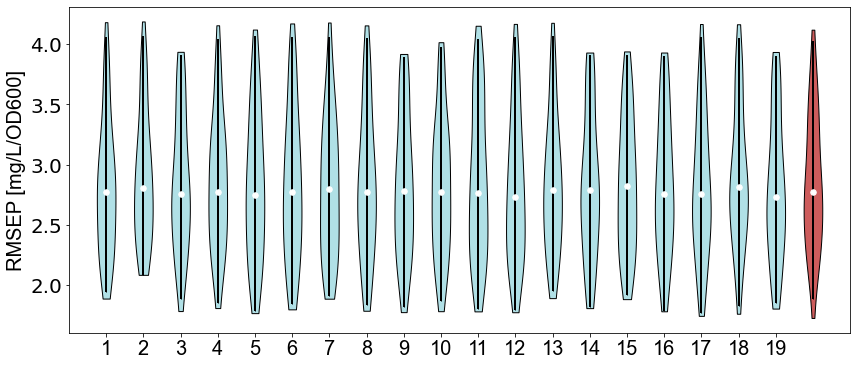

In [13]:
plt_data = RMSEP
plt.figure()
params = {'axes.titlesize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20}
hfont = {'fontname':'Arial'} #, 'weight' : 'bold'
plt.rcParams.update(params)
plt.rcParams["figure.figsize"] = (14, 6)
f, ax = plt.subplots(1, 1)
parts = plt.violinplot(plt_data, showmeans=False, showmedians=False,
        showextrema=False)

cnt = 0
alpha_list = [1, 0.7, 0.5, 0.3]
for pc in parts['bodies']:
    if cnt == 19:
        pc.set_facecolor('indianred')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    else:
        pc.set_facecolor('powderblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    cnt = cnt+1


quartile1, medians, quartile3 = np.percentile(np.transpose(plt_data), [1, 50, 99], axis=1)
whiskers = np.array([adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(plt_data, quartile1, quartile3)])

whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
ax.set_ylabel("RMSEP [mg/L/OD600]", **hfont)
ax.set_xlim([0, 21])
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(np.arange(1,20), **hfont)

plt.savefig("RMSEP_9fac.pdf", dpi = 600, bbox_inches = "tight")